# 1. Calibração

1.  Configuração: Definição dos parâmetros de entrada (ativos, juros, `kappa_list`) e dos dicionários para a otimização (`otim`, `funcs`).
2.  Loop Principal (Grid Search):
    * Iteração sobre cada ativo (`ticker`).
    * Limpeza dos dados de mercado (`cf.calibration_cleaning`).
    * Estimativa da variância inicial `v0` (`cf.v0_estimator`).
    * Conversão do DataFrame para o formato de lista (`data_list`).
3.  Loop Interno (Otimização):
    * Iteração sobre cada valor de `kappa` para o ativo.
    * Execução da otimização `cf.ac_pg` para encontrar os parâmetros (`v_bar`, `gamma`, `rho`).
4.  Resultados: Agrupamento dos resultados para encontrar o melhor `kappa` (menor erro) para cada ativo e salvamento dos arquivos CSV (`grid_search_results.csv` e `best_results.csv`).

In [ ]:
import numpy as np
import pandas as pd
import os
import heston_pricing as hp
import calibration_functions as cf
import time

ativos = {
'BBAS3': 21.12,
'BBDC4': 16.48,
'ITUB4': 38.40,
'PETR4': 30.91,
'VALE3': 56.08
}

# Taxa de juros
r = 0.15

# Lista de kappas
kappa_list = [0.15, 0.5, 1, 1.5, 2, 3, 5, 7]

# Vetor inicial
theta0 = np.array([0.08, 0.1, -0.8])

# Mapeando colunas do DataFrame para a função de perda (loss_vol)
col_loss = {
    'equiv_price': 'equiv_price',
    'K': 'K',
    'tau (anos)': 'tau'
}

# Configurando os parâmetros do otimizador
otim = {
    'theta0': theta0,
    'M0': 1,         
    'max_iter': 200,    
    'tol': 1e-4
}

# Agrupando as funções necessárias para o otimizador
funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


all_results = []

print('Iniciando calibração de todos os conjuntos de dados com grid search')
start_total_time = time.time()

# Loop por ativo
for ticker, spot in ativos.items():
    print(f'Calibrando {ticker}')

    try:
        # Limpando e preparando os dados do ativo
        dataset = cf.calibration_cleaning(ticker, spot)
        if dataset is None or dataset.empty:
            print(f'Sem dados para {ticker}')
            continue

        # Estimando v0
        v0 = cf.v0_estimator(dataset, spot)
        # Convertendo o DataFrame para a lista de otimização
        data_list = cf.df_converter(dataset, col_loss)

        if not data_list:
            print(f'Dados vazios para {ticker} após filtro')
            continue
    except Exception as e:
        print(f'Erro na preparação dos dados para {ticker}: {e}')
        continue

    asset_results = []
    print(f'v0 estimado: {v0:.4f}. Iniciando grid search')

    # Loop interno (grid search)
    for kappa in kappa_list:

        # Definindo os parâmetros fixos para a rodada
        params = {
            'spot': spot,        
            'r': r,              
            'v0': v0,            
            'kappa': kappa,
            'data_list': data_list 
        }
        
        # Rodando a otimização
        theta_final, hist_custo = cf.ac_pg(funcs=funcs, otim=otim, params=params)

        if hist_custo:
            print(f'kappa: {kappa:<4} -> Erro final: {hist_custo[-1]:.6f}')
        else:
            print(f'kappa: {kappa:<4} -> Falha na otimização')

        # Salvando os resultados
        if theta_final is not None and hist_custo:
            asset_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'erro final': hist_custo[-1],
                'v_bar': theta_final[0],
                'gamma': theta_final[1],
                'rho': theta_final[2]
            })
        else:
            asset_results.append({
                'ticker': ticker, 'kappa': kappa, 'erro final': np.inf,
                'v_bar': np.nan, 'gamma': np.nan, 'rho': np.nan
            })

    if not asset_results:
        print(f'Nenhum resultado de calibração para {ticker}')
        continue

    all_results.extend(asset_results)

    # Tabela de grid search do ativo
    df_asset = pd.DataFrame(asset_results)
    df_asset = df_asset[df_asset['ticker'] == ticker]
    print(f'Grid search concluído para {ticker}')
    with pd.option_context('display.precision', 6):
        print(df_asset.sort_values(by='erro final').to_string(index=False))


end_total_time = time.time()
print(f'Calibração dos dados concluída em {(end_total_time - start_total_time)/60:.2f} minutos')

if not all_results:
    print('Nenhuma calibração foi bem sucedida')

else:
    df_all = pd.DataFrame(all_results)

    # Encontrando o 'kappa' com menor erro para cada 'ticker'
    idx_best = df_all.groupby('ticker')['erro final'].idxmin()
    best_results = df_all.loc[idx_best]
    best_results = best_results.sort_values(by='erro final')


    output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'

    # Salvando todos os resultados do grid search
    all_results_path = os.path.join(output_dir, 'grid_search_results.csv')
    df_all.to_csv(all_results_path, index=False, decimal='.', sep=',')

    # Salvando apenas os melhores resultados
    best_results_path = os.path.join(output_dir, 'best_results.csv')
    best_results.to_csv(best_results_path, index=False, decimal='.', sep=',')


print('Resumo: melhores parâmetros por ativo')
with pd.option_context('display.precision', 6, 'display.width', 100):
    print(best_results)


Iniciando calibração de todos os conjuntos de dados com grid search
Calibrando BBAS3
v0 estimado: 0.1116. Iniciando grid search
kappa: 0.15 -> Erro final: 0.038493
kappa: 0.5  -> Erro final: 0.029130
kappa: 1    -> Erro final: 0.020222
kappa: 1.5  -> Erro final: 0.016052
kappa: 2    -> Erro final: 0.014429
kappa: 3    -> Erro final: 0.011985
kappa: 5    -> Erro final: 0.013568
kappa: 7    -> Erro final: 0.014023
Grid search concluído para BBAS3
ticker  kappa  erro final    v_bar    gamma       rho
 BBAS3   3.00    0.011985 0.098573 0.769048 -0.762411
 BBAS3   5.00    0.013568 0.102912 0.708548 -0.915999
 BBAS3   7.00    0.014023 0.104692 0.699088 -0.980934
 BBAS3   2.00    0.014429 0.093429 0.611324 -0.874857
 BBAS3   1.50    0.016052 0.088443 0.515100 -0.985913
 BBAS3   1.00    0.020222 0.080995 0.402481 -0.999000
 BBAS3   0.50    0.029130 0.087061 0.295061 -0.999000
 BBAS3   0.15    0.038493 0.159993 0.219084 -0.999000
Calibrando BBDC4
v0 estimado: 0.0520. Iniciando grid search
kappa

## 2. Cálculo das volatilidades do modelo

O script itera sobre cada ativo para:
1.  Recarregar os dados de mercado originais.
2.  Calcular o preço teórico de Heston (`hp.heston_call_price`) com os parâmetros ótimos.
3.  Calcular a volatilidade implícita (`bs.vol_imp`) desse preço teórico.
4.  Armazenar os resultados (`model_vol` e `vol_error`) no dicionário `dataframes` para plotagem.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs


output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
best_results_path = os.path.join(output_dir, 'best_results.csv')

best_results = pd.read_csv(best_results_path, decimal='.', sep=',')

# Configurações iniciais
spots = {
'BBAS3': 21.12,
'BBDC4': 16.48,
'ITUB4': 38.40,
'PETR4': 30.91,
'VALE3': 56.08
}

r = 0.15

dataframes = {}

# Loop sobre os ativos
for ticker in best_results['ticker']:
    spot = spots.get(ticker)
    dataset = cf.calibration_cleaning(ticker=ticker, spot=spot, r=r)

    opt_params = best_results.loc[best_results['ticker'] == ticker].iloc[0]
    v0 = cf.v0_estimator(df=dataset, spot=spot)

    # Descompactando
    opt_kappa = opt_params['kappa']
    opt_vbar = opt_params['v_bar']
    opt_gamma = opt_params['gamma']
    opt_rho = opt_params['rho']

    model_vols = []

    for index, row in dataset.iterrows():
        # Pega os dados da linha
        K = row['K']
        tau = row['tau (anos)']
        vol_mkt = row['vol. imp.']
        C_mkt = row['equiv_price']

        # Calcula o preço teórico
        V = hp.heston_call_price(S0=spot, K=K, r=r, tau=tau, v0=v0, kappa=opt_kappa, v_bar=opt_vbar, gamma=opt_gamma, rho=opt_rho)
        
        # Calcula a vol. imp. teórica
        vol = bs.vol_imp(C_mkt=V, S=spot, K=K, tau=tau, r=r, sigma_inicial=vol_mkt)
        
        if not np.isfinite(vol):
            vol = np.nan

        model_vols.append(vol)

    # Acrescenta os dados ao dataframe
    dataset['model_vol'] = model_vols
    dataset['vol_error'] = dataset['vol. imp.'] - dataset['model_vol']

    # Removendo linhas onde a vol do modelo não pôde ser calculada
    dataset = dataset.dropna(subset=['model_vol', 'vol. imp.'])

    # Guardando o dataframe final para plotagem
    dataframes[ticker] = dataset.copy()

## 3. Plotando o smile

Definição da função `calib_smile`.

Esta função filtra os dados por um vencimento específico (`dias_uteis`) e plota o smile de volatilidade do Mercado (pontos)
contra o Modelo Heston (linha tracejada).
O gráfico é salvo na pasta `/Figuras`.

In [ ]:
def calib_smile(df: Dict[str, pd.DataFrame], ticker: str, dias_uteis: int = 36):
    '''
    Plota o smile de volatilidade (Mercado vs. Heston) para um ativo e vencimento.

    Recebe como parâmetros:
    df: dict -> Dicionário contendo os DataFrames de todos os ativos
    ticker: str -> Ticker do ativo a ser plotado
    dias_uteis: int -> Vencimento (em dias úteis) a ser filtrado para o gráfico
    
    Exibe e salva o gráfico do smile.
    '''

    # Pegando os parâmetros ótimos do ticker
    opt_params = best_results.loc[best_results['ticker'] == ticker].iloc[0]
    tau = dias_uteis/252

    df = df[ticker]
    # Filtrando o DataFrame apenas para o vencimento escolhido
    df = df[df['tau (anos)'] == tau]

    opt_kappa = opt_params['kappa']
    asset_error = opt_params['erro final']

    # Configurando a figura e os eixos do gráfico
    fig, ax = plt.subplots(1, 1, figsize=(11, 7)) 
    fig.subplots_adjust(bottom=0.2)

    # Plotando os dados de Mercado
    mkt = ax.plot(
    df['K'], 
    df['vol. imp.'],
    label='Mercado',
    marker='o',
    linestyle='None',
    color="#1C849B",
    markersize=7,    
    alpha=0.8
    )

    # Plotando os dados do modelo
    heston = ax.plot(
    df['K'], 
    df['model_vol'],
    label='Heston',
    linestyle='--',
    color="#af060e",
    linewidth=2.3,
    alpha=0.9
    )


    # Configurações do gráfico
    ax.set_title(f'{ticker} vs Heston', fontsize=23)
    ax.set_xlabel('Preço de Exercício', fontsize=20)
    ax.set_ylabel('Volatilidade Implícita', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Formatando o eixo Y para percentual
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
    ax.legend(
    loc='best',
    fontsize=17,
    frameon=True,
    shadow=False,
    facecolor='white',
    edgecolor='grey')

    
    output_dir = 'Figuras'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    arquivo = f'ajuste_{ticker}_venc_{dias_uteis}.pdf'
    caminho = os.path.join(output_dir, arquivo)
    plt.savefig(caminho, dpi=300, bbox_inches='tight')

    plt.show()

## 4. Smiles

### 4.1. Ajuste BBAS3 (Venc. 36 dias)

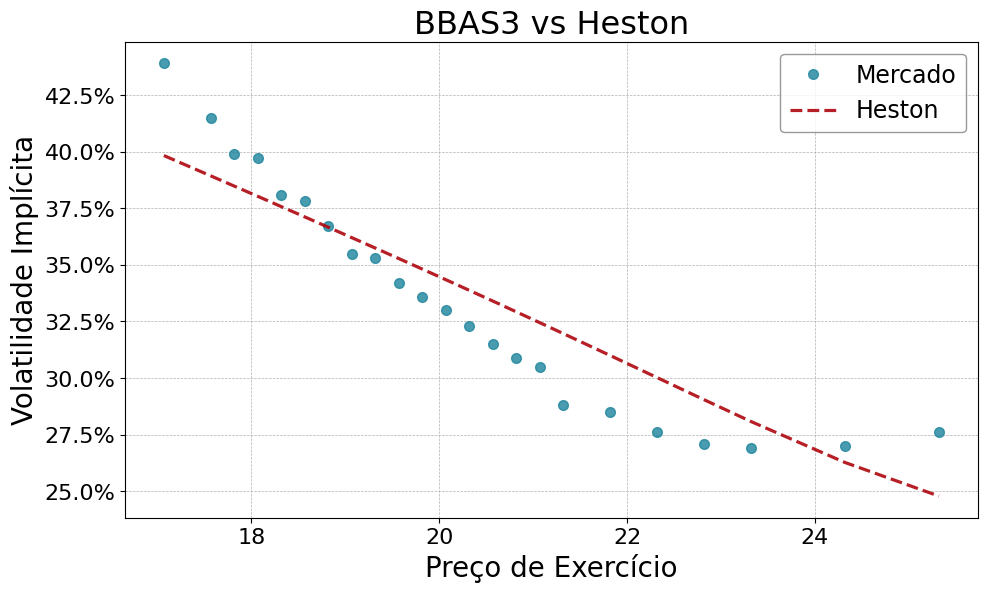

In [21]:
calib_smile(df=dataframes, ticker='BBAS3')

### 4.2. Ajuste BBDC4 (Venc. 36 dias)

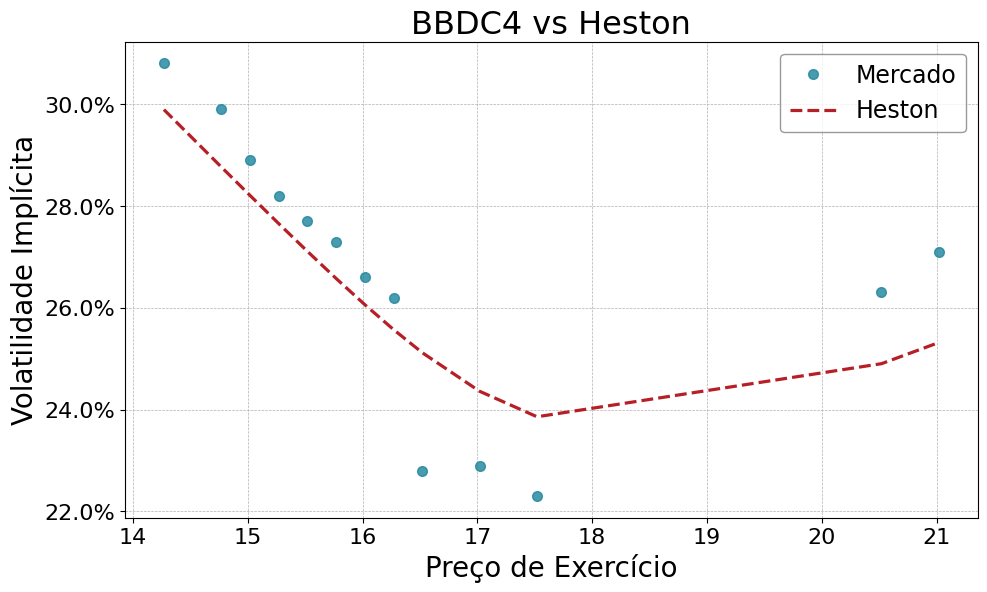

In [6]:
calib_smile(df=dataframes, ticker='BBDC4')

### 4.3. Ajuste ITUB4 (Venc. 36 dias)

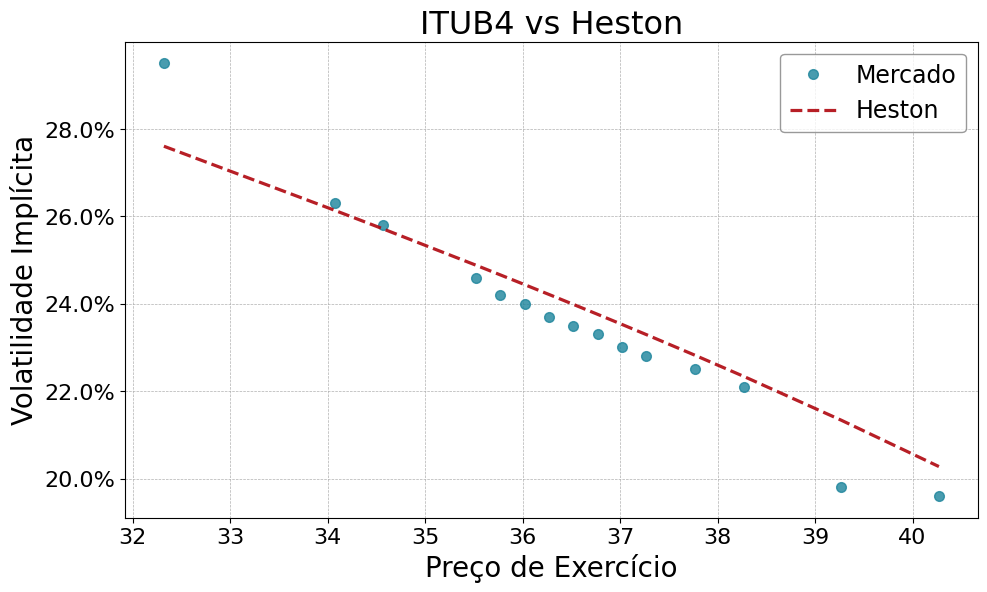

In [7]:
calib_smile(df=dataframes, ticker='ITUB4')

### 4.4. Ajuste PETR4 (Venc. 36 dias)

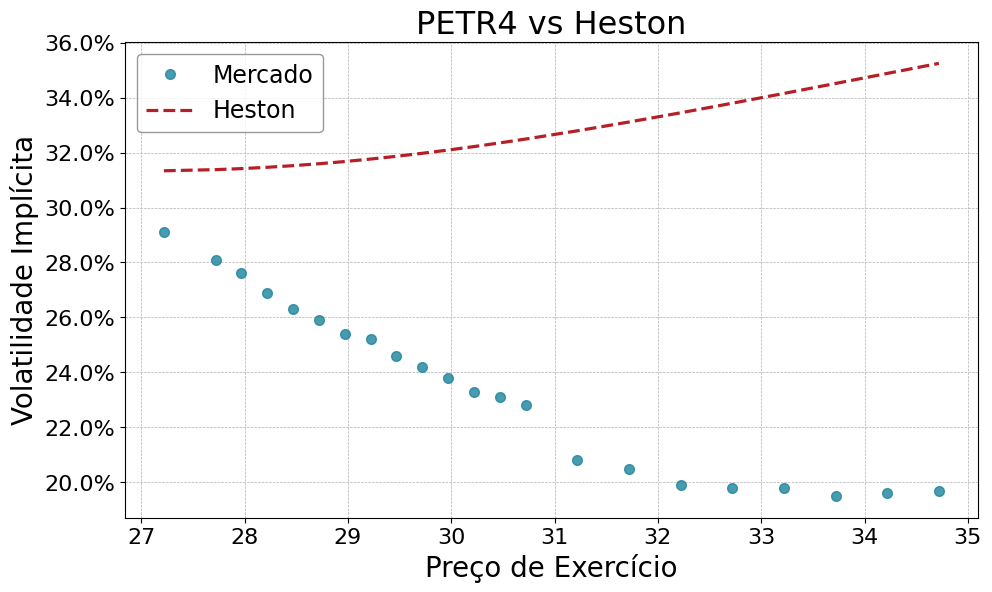

In [8]:
calib_smile(df=dataframes, ticker='PETR4')

### 4.5. Ajuste VALE3 (Venc. 36 dias)

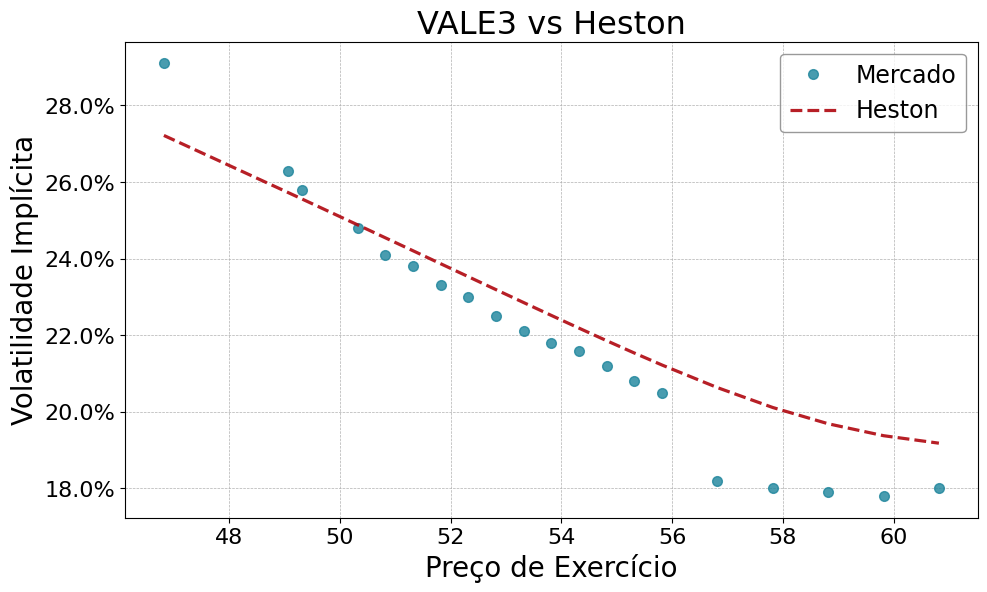

In [9]:
calib_smile(df=dataframes, ticker='VALE3')

# 5. Teste Multi-Start

Teste da robustez da calibração para os valores de $\kappa$ de menor erro.

O otimizador `ac_pg` será executado 20 vezes (`n_starts = 20`) para cada ativo, cada vez com um ponto inicial aleatório (`theta0`), para verificar a convergência a um mínimo global.

### $\kappa = 1$ (BBDC4 e ITUB4)

In [ ]:
import pandas as pd
import numpy as np
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs

tickers = ['BBDC4', 'ITUB4']
spots ={
'BBDC4': 16.48,
'ITUB4': 38.40
}

r = 0.15
kappa = 1 # Fixo

n_starts = 20

# Definindo os limites para a geração aleatória do chute inicial (theta0)
lim_params = {
    'v_bar': (0.08, 1),
    'gamma': (0.1, 3),
    'rho': (-0.999, -0.1)
}

# Mapeamento para a função de perda (loss_vol)
col_loss = {
    'equiv_price': 'V_mkt',
    'K': 'K',
    'tau (anos)': 'tau'
}

# Agrupando as funções para o otimizador
funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


print(f'Iniciando teste multi-start (n = {n_starts}) para BBDC4 e ITUB4 com kappa = {kappa}')
start_time_total = time.time()

best_results_final = []     # Armazena o melhor resultado de cada ticker
all_runs = []

for ticker in tickers:
    print(f'Processando: {ticker}')
    
    # Preparando os dados (limpeza, v0, conversão)
    spot = spots.get(ticker)

    data = cf.calibration_cleaning(ticker, spot, r)
    v0 = cf.v0_estimator(data, spot)
    data_otim = cf.df_converter(data, col_loss)

    # Parâmetros fixos do modelo
    params = {'spot': spot,
            'r': r,
            'v0': v0,
            'kappa': kappa,
            'data_list': data_otim
            }

    ticker_results = [] # Lista para os 20 runs deste ticker

    print(f'Iniciando {n_starts} rodadas de otimização')
    start_time_ticker = time.time()

    # Multi-Start
    for i in range(n_starts):

        # Garantindo reprodutibilidade
        np.random.seed(i)
        v_bar0 = np.random.uniform(lim_params['v_bar'][0], lim_params['v_bar'][1])
        gamma0 = np.random.uniform(lim_params['gamma'][0], lim_params['gamma'][1])
        rho0 = np.random.uniform(lim_params['rho'][0], lim_params['rho'][1])

        theta0 = np.array([v_bar0, gamma0, rho0])

        # Configurando o otimizador com o chute inicial aleatório
        otim = {
            'theta0': theta0,
            'M0': 1,        
            'max_iter': 200,    
            'tol': 1e-4
            }
        print(f'Rodada {i+1}/{n_starts} | theta0 = ({v_bar0:.3f}, {gamma0:.3f}, {rho0:.3f})')

        # Rodando a otimização
        theta_final, hist_custo = cf.ac_pg(funcs, otim, params)
        
        # Salvando os resultados deste run
        if theta_final is not None and hist_custo and len(hist_custo) > 0:
            erro_final = hist_custo[-1]
            (v_bar_final, gamma_final, rho_final) = theta_final

            ticker_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'run': i+1,
                'erro_final': erro_final,
                'v_bar': v_bar_final,
                'gamma': gamma_final,
                'rho': rho_final,
                'v_bar0': v_bar0, 
                'gamma0': gamma0, 
                'rho0': rho0      
            })
        else:
            print(f"Rodada {i+1} falhou na otimização e será descartada.")
    
    if not ticker_results:
        print(f'Nenhuma otimização teve sucesso para {ticker}')
        continue

    # Guardando todos os runs
    all_runs.extend(ticker_results)

    # Selecionando o melhor run (menor erro) para este ticker
    best_result_ticker = sorted(ticker_results, key=lambda x: x['erro_final'])[0]

    # Guardando o melhor run
    best_results_final.append({
        'ticker': ticker,
        'kappa': kappa,
        'erro_final': best_result_ticker['erro_final'],
        'v_bar': best_result_ticker['v_bar'],
        'gamma': best_result_ticker['gamma'],
        'rho': best_result_ticker['rho']
    })

    
print(f'Teste multi-start concluído')
print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

df_resumo = pd.DataFrame(best_results_final)

output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
filename = f'multistart_kappa_{kappa}.csv'
output_path = os.path.join(output_dir, filename)
df_resumo.to_csv(output_path, index=False, decimal='.', sep=',')

print(f'\nResultados do RESUMO (melhor run) salvos em: {output_path}')


if not all_runs:
    print('Nenhum dado salvo')
else:
    df_appendix = pd.DataFrame(all_runs)
    appendix_filename = f'ALL_multistart_k{kappa}.csv'
    appendix_path = os.path.join(output_dir, appendix_filename)
    
    df_appendix.to_csv(appendix_path, index=False, decimal='.', sep=',')
    print(f'Resultados DETALHADOS (todos os {len(df_appendix)} runs) salvos em: {appendix_path}')

Iniciando teste multi-start (n = 20) para BBDC4 e ITUB4 com kappa = 1
Processando: BBDC4
Iniciando 20 rodadas de otimização
Rodada 1/20 | theta0 = (0.585, 2.174, -0.457)
Rodada 2/20 | theta0 = (0.464, 2.189, -0.999)


c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_imp = sigma_inicial - g/vega
c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:17: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))
c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:40: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))


Aviso: Vol. imp. inválida (nan) para K=18.88, tau=0.23809523809523808. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=21.02, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=18.88, tau=0.23809523809523808. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=21.02, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=18.88, tau=0.23809523809523808. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=21.02, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=18.88, tau=0.23809523809523808. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=21.02, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=18.88, tau=0.23809523809523808. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=21.02, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=20.52, tau=0.14285714285714285. Aplicando

### $\kappa = 3$ (BBAS3 e VALE3)

Teste multi-start (n=20) para BBAS3 e VALE3, que tiveram melhor performance com $\kappa = 3$.

In [23]:
import pandas as pd
import numpy as np
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs

tickers = ['BBAS3', 'VALE3']
spots ={
'BBAS3': 21.12,
'VALE3': 56.08
}

r = 0.15
kappa = 3

n_starts = 20

lim_params = {
    'v_bar': (0.08, 1),
    'gamma': (0.1, 3),
    'rho': (-0.999, -0.1)
}

col_loss = {
    'equiv_price': 'V_mkt',
    'K': 'K',
    'tau (anos)': 'tau'
}

funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


print(f'Iniciando teste multi-start (n = {n_starts}) para BBAS3 e VALE3 com kappa = {kappa}')
start_time_total = time.time()

best_results_final = []
all_runs = []

for ticker in tickers:
    print(f'Processando: {ticker}')

    spot = spots.get(ticker)

    data = cf.calibration_cleaning(ticker, spot, r)
    v0 = cf.v0_estimator(data, spot)
    data_otim = cf.df_converter(data, col_loss)

    params = {'spot': spot,
            'r': r,
            'v0': v0,
            'kappa': kappa,
            'data_list': data_otim
            }

    ticker_results = [] # Lista para os 20 runs deste ticker

    print(f'Iniciando {n_starts} rodadas de otimização')
    start_time_ticker = time.time()

    # Multi-Start
    for i in range(n_starts):
        
        np.random.seed(i) # Use 'i' como semente (0, 1, 2...)
        v_bar0 = np.random.uniform(lim_params['v_bar'][0], lim_params['v_bar'][1])
        gamma0 = np.random.uniform(lim_params['gamma'][0], lim_params['gamma'][1])
        rho0 = np.random.uniform(lim_params['rho'][0], lim_params['rho'][1])

        theta0 = np.array([v_bar0, gamma0, rho0])

        otim = {
            'theta0': theta0,
            'M0': 1,        
            'max_iter': 200,    
            'tol': 1e-4
            }
        print(f'Rodada {i+1}/{n_starts} | theta0 = ({v_bar0:.3f}, {gamma0:.3f}, {rho0:.3f})')

        theta_final, hist_custo = cf.ac_pg(funcs, otim, params)
        
        if theta_final is not None and hist_custo and len(hist_custo) > 0:
            erro_final = hist_custo[-1]
            (v_bar_final, gamma_final, rho_final) = theta_final

            ticker_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'run': i+1,
                'erro_final': erro_final,
                'v_bar': v_bar_final,
                'gamma': gamma_final,
                'rho': rho_final,
                'v_bar0': v_bar0, 
                'gamma0': gamma0, 
                'rho0': rho0      
            })
        else:
            print(f"Rodada {i+1} falhou na otimização e será descartada.")
    
    if not ticker_results:
        print(f'Nenhuma otimização teve sucesso para {ticker}')
        continue

    all_runs.extend(ticker_results)

    best_result_ticker = sorted(ticker_results, key=lambda x: x['erro_final'])[0]

    best_results_final.append({
        'ticker': ticker,
        'kappa': kappa,
        'erro_final': best_result_ticker['erro_final'],
        'v_bar': best_result_ticker['v_bar'],
        'gamma': best_result_ticker['gamma'],
        'rho': best_result_ticker['rho']
    })

    
print(f'Teste multi-start concluído')
print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

df_resumo = pd.DataFrame(best_results_final)

output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
filename = f'multistart_kappa_{kappa}.csv'
output_path = os.path.join(output_dir, filename)
df_resumo.to_csv(output_path, index=False, decimal='.', sep=',')

print(f'\nResultados do RESUMO (melhor run) salvos em: {output_path}')


if not all_runs:
    print('Nenhum dado salvo para o Apêndice.')
else:
    df_appendix = pd.DataFrame(all_runs)
    appendix_filename = f'multistart_APENDICE_k{kappa}.csv'
    appendix_path = os.path.join(output_dir, appendix_filename)
    
    df_appendix.to_csv(appendix_path, index=False, decimal='.', sep=',')
    print(f'Resultados DETALHADOS (todos os {len(df_appendix)} runs) salvos em: {appendix_path}')

Iniciando teste multi-start (n = 20) para BBAS3 e VALE3 com kappa = 3
Processando: BBAS3
Iniciando 20 rodadas de otimização
Rodada 1/20 | theta0 = (0.585, 2.174, -0.457)
Rodada 2/20 | theta0 = (0.464, 2.189, -0.999)


c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_imp = sigma_inicial - g/vega
c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:17: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))
c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:40: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))


Aviso: Vol. imp. inválida (nan) para K=25.32, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=25.32, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=25.32, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=25.32, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=25.32, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=17.07, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=17.5, tau=0.12301587301587301. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=17.57, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=17.82, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=17.94, tau=0.31746031746031744. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=18.0, tau=0.12301587301587301. Aplicando p

### Análise PETR4 (Multi-Start com vários $\kappa$)

Análise detalhada para PETR4, que apresentou erros elevados.
Teste multi-start (n=20) para os valores de $\kappa$ (0.5, 1, 3 e 7).

#### PETR4 ($\kappa$=0.5)

In [ ]:
import pandas as pd
import numpy as np
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs

tickers = ['PETR4']
spots ={
'PETR4': 30.91
}

r = 0.15
kappa = 0.5

n_starts = 20

lim_params = {
    'v_bar': (0.08, 1),
    'gamma': (0.1, 3),
    'rho': (-0.999, -0.1)
}

col_loss = {
    'equiv_price': 'V_mkt',
    'K': 'K',
    'tau (anos)': 'tau'
}

funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


print(f'Iniciando teste multi-start (n = {n_starts}) para BBAS3 e VALE3 com kappa = {kappa}')
start_time_total = time.time()

best_results_final = []
all_runs = []

for ticker in tickers:
    print(f'Processando: {ticker}')

    spot = spots.get(ticker)

    data = cf.calibration_cleaning(ticker, spot, r)
    v0 = cf.v0_estimator(data, spot)
    data_otim = cf.df_converter(data, col_loss)

    params = {'spot': spot,
            'r': r,
            'v0': v0,
            'kappa': kappa,
            'data_list': data_otim
            }

    ticker_results = [] # Lista para os 20 runs deste ticker

    print(f'Iniciando {n_starts} rodadas de otimização')
    start_time_ticker = time.time()

    # Multi-Start
    for i in range(n_starts):
        
        np.random.seed(i) # Use 'i' como semente (0, 1, 2...)
        v_bar0 = np.random.uniform(lim_params['v_bar'][0], lim_params['v_bar'][1])
        gamma0 = np.random.uniform(lim_params['gamma'][0], lim_params['gamma'][1])
        rho0 = np.random.uniform(lim_params['rho'][0], lim_params['rho'][1])

        theta0 = np.array([v_bar0, gamma0, rho0])

        otim = {
            'theta0': theta0,
            'M0': 1,        
            'max_iter': 200,    
            'tol': 1e-4
            }
        print(f'Rodada {i+1}/{n_starts} | theta0 = ({v_bar0:.3f}, {gamma0:.3f}, {rho0:.3f})')

        theta_final, hist_custo = cf.ac_pg(funcs, otim, params)
        
        if theta_final is not None and hist_custo and len(hist_custo) > 0:
            erro_final = hist_custo[-1]
            (v_bar_final, gamma_final, rho_final) = theta_final

            ticker_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'run': i+1,
                'erro_final': erro_final,
                'v_bar': v_bar_final,
                'gamma': gamma_final,
                'rho': rho_final,
                'v_bar0': v_bar0, 
                'gamma0': gamma0, 
                'rho0': rho0      
            })
        else:
            print(f"Rodada {i+1} falhou na otimização e será descartada.")
    
    if not ticker_results:
        print(f'Nenhuma otimização teve sucesso para {ticker}')
        continue

    all_runs.extend(ticker_results)

    best_result_ticker = sorted(ticker_results, key=lambda x: x['erro_final'])[0]

    best_results_final.append({
        'ticker': ticker,
        'kappa': kappa,
        'erro_final': best_result_ticker['erro_final'],
        'v_bar': best_result_ticker['v_bar'],
        'gamma': best_result_ticker['gamma'],
        'rho': best_result_ticker['rho']
    })

    
print(f'Teste multi-start concluído')
print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

df_resumo = pd.DataFrame(best_results_final)

output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
filename = f'multistart_kappa_{kappa}.csv'
output_path = os.path.join(output_dir, filename)
df_resumo.to_csv(output_path, index=False, decimal='.', sep=',')

print(f'\nResultados do RESUMO (melhor run) salvos em: {output_path}')


if not all_runs:
    print('Nenhum dado salvo para o Apêndice.')
else:
    df_appendix = pd.DataFrame(all_runs)
    appendix_filename = f'multistart_k{kappa}_PETR.csv'
    appendix_path = os.path.join(output_dir, appendix_filename)
    
    df_appendix.to_csv(appendix_path, index=False, decimal='.', sep=',')
    print(f'Resultados DETALHADOS (todos os {len(df_appendix)} runs) salvos em: {appendix_path}')

Iniciando teste multi-start (n = 20) para BBAS3 e VALE3 com kappa = 0.5
Processando: PETR4
Iniciando 20 rodadas de otimização
Rodada 1/20 | theta0 = (0.585, 2.174, -0.457)
Rodada 2/20 | theta0 = (0.464, 2.189, -0.999)


c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_imp = sigma_inicial - g/vega
c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:17: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))
c:\Pedro\Python\Dissertação\Códigos\Códigos GitHub\BS_equations.py:40: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))


Aviso: Vol. imp. inválida (nan) para K=34.72, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=34.72, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=34.72, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=34.72, tau=0.14285714285714285. Aplicando penalidade
Aviso: Vol. imp. inválida (nan) para K=34.72, tau=0.14285714285714285. Aplicando penalidade
Rodada 3/20 | theta0 = (0.481, 0.175, -0.505)
Rodada 4/20 | theta0 = (0.587, 2.154, -0.737)
Rodada 5/20 | theta0 = (0.970, 1.687, -0.125)
Rodada 6/20 | theta0 = (0.284, 2.625, -0.813)
Rodada 7/20 | theta0 = (0.901, 1.063, -0.261)
Rodada 8/20 | theta0 = (0.150, 2.362, -0.605)
Rodada 9/20 | theta0 = (0.884, 2.909, -0.218)
Rodada 10/20 | theta0 = (0.090, 1.555, -0.553)
Rodada 11/20 | theta0 = (0.790, 0.160, -0.429)
Rodada 12/20 | theta0 = (0.246, 0.156, -0.583)
Rodada 13/20 | theta0 = (0.222, 2.246, -0.762)
Rodada 14/20 | theta0 = (0.795

#### PETR4 ($\kappa$=1)

In [25]:
import pandas as pd
import numpy as np
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs

tickers = ['PETR4']
spots ={
'PETR4': 30.91
}

r = 0.15
kappa = 1

n_starts = 20

lim_params = {
    'v_bar': (0.08, 1),
    'gamma': (0.1, 3),
    'rho': (-0.999, -0.1)
}

col_loss = {
    'equiv_price': 'V_mkt',
    'K': 'K',
    'tau (anos)': 'tau'
}

funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


print(f'Iniciando teste multi-start (n = {n_starts}) para BBAS3 e VALE3 com kappa = {kappa}')
start_time_total = time.time()

best_results_final = []
all_runs = []

for ticker in tickers:
    print(f'Processando: {ticker}')

    spot = spots.get(ticker)

    data = cf.calibration_cleaning(ticker, spot, r)
    v0 = cf.v0_estimator(data, spot)
    data_otim = cf.df_converter(data, col_loss)

    params = {'spot': spot,
            'r': r,
            'v0': v0,
            'kappa': kappa,
            'data_list': data_otim
            }

    ticker_results = [] # Lista para os 20 runs deste ticker

    print(f'Iniciando {n_starts} rodadas de otimização')
    start_time_ticker = time.time()

    # Multi-Start
    for i in range(n_starts):
        
        np.random.seed(i) # Use 'i' como semente (0, 1, 2...)
        v_bar0 = np.random.uniform(lim_params['v_bar'][0], lim_params['v_bar'][1])
        gamma0 = np.random.uniform(lim_params['gamma'][0], lim_params['gamma'][1])
        rho0 = np.random.uniform(lim_params['rho'][0], lim_params['rho'][1])

        theta0 = np.array([v_bar0, gamma0, rho0])

        otim = {
            'theta0': theta0,
            'M0': 1,        
            'max_iter': 200,    
            'tol': 1e-4
            }
        print(f'Rodada {i+1}/{n_starts} | theta0 = ({v_bar0:.3f}, {gamma0:.3f}, {rho0:.3f})')

        theta_final, hist_custo = cf.ac_pg(funcs, otim, params)
        
        if theta_final is not None and hist_custo and len(hist_custo) > 0:
            erro_final = hist_custo[-1]
            (v_bar_final, gamma_final, rho_final) = theta_final

            ticker_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'run': i+1,
                'erro_final': erro_final,
                'v_bar': v_bar_final,
                'gamma': gamma_final,
                'rho': rho_final,
                'v_bar0': v_bar0, 
                'gamma0': gamma0, 
                'rho0': rho0      
            })
        else:
            print(f"Rodada {i+1} falhou na otimização e será descartada.")
    
    if not ticker_results:
        print(f'Nenhuma otimização teve sucesso para {ticker}')
        continue

    all_runs.extend(ticker_results)

    best_result_ticker = sorted(ticker_results, key=lambda x: x['erro_final'])[0]

    best_results_final.append({
        'ticker': ticker,
        'kappa': kappa,
        'erro_final': best_result_ticker['erro_final'],
        'v_bar': best_result_ticker['v_bar'],
        'gamma': best_result_ticker['gamma'],
        'rho': best_result_ticker['rho']
    })

    
print(f'Teste multi-start concluído')
print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

df_resumo = pd.DataFrame(best_results_final)

output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
filename = f'multistart_kappa_{kappa}.csv'
output_path = os.path.join(output_dir, filename)
df_resumo.to_csv(output_path, index=False, decimal='.', sep=',')

print(f'\nResultados do RESUMO (melhor run) salvos em: {output_path}')


if not all_runs:
    print('Nenhum dado salvo para o Apêndice.')
else:
    df_appendix = pd.DataFrame(all_runs)
    appendix_filename = f'multistart_k{kappa}_PETR4.csv'
    appendix_path = os.path.join(output_dir, appendix_filename)
    
    df_appendix.to_csv(appendix_path, index=False, decimal='.', sep=',')
    print(f'Resultados DETALHADOS (todos os {len(df_appendix)} runs) salvos em: {appendix_path}')

Iniciando teste multi-start (n = 20) para BBAS3 e VALE3 com kappa = 1
Processando: PETR4
Iniciando 20 rodadas de otimização
Rodada 1/20 | theta0 = (0.585, 2.174, -0.457)
Rodada 2/20 | theta0 = (0.464, 2.189, -0.999)
Rodada 3/20 | theta0 = (0.481, 0.175, -0.505)
Rodada 4/20 | theta0 = (0.587, 2.154, -0.737)
Rodada 5/20 | theta0 = (0.970, 1.687, -0.125)
Rodada 6/20 | theta0 = (0.284, 2.625, -0.813)
Rodada 7/20 | theta0 = (0.901, 1.063, -0.261)
Rodada 8/20 | theta0 = (0.150, 2.362, -0.605)
Rodada 9/20 | theta0 = (0.884, 2.909, -0.218)
Rodada 10/20 | theta0 = (0.090, 1.555, -0.553)
Rodada 11/20 | theta0 = (0.790, 0.160, -0.429)
Rodada 12/20 | theta0 = (0.246, 0.156, -0.583)
Rodada 13/20 | theta0 = (0.222, 2.246, -0.762)
Rodada 14/20 | theta0 = (0.795, 0.789, -0.258)
Rodada 15/20 | theta0 = (0.553, 2.342, -0.216)
Rodada 16/20 | theta0 = (0.861, 0.619, -0.950)
Rodada 17/20 | theta0 = (0.285, 1.617, -0.504)
Rodada 18/20 | theta0 = (0.351, 1.639, -0.827)
Rodada 19/20 | theta0 = (0.678, 1.566, 

#### PETR4 ($\kappa$=3)

In [26]:
import pandas as pd
import numpy as np
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs

tickers = ['PETR4']
spots ={
'PETR4': 30.91
}

r = 0.15
kappa = 3

n_starts = 20

lim_params = {
    'v_bar': (0.08, 1),
    'gamma': (0.1, 3),
    'rho': (-0.999, -0.1)
}

col_loss = {
    'equiv_price': 'V_mkt',
    'K': 'K',
    'tau (anos)': 'tau'
}

funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


print(f'Iniciando teste multi-start (n = {n_starts}) para BBAS3 e VALE3 com kappa = {kappa}')
start_time_total = time.time()

best_results_final = []
all_runs = []

for ticker in tickers:
    print(f'Processando: {ticker}')

    spot = spots.get(ticker)

    data = cf.calibration_cleaning(ticker, spot, r)
    v0 = cf.v0_estimator(data, spot)
    data_otim = cf.df_converter(data, col_loss)

    params = {'spot': spot,
            'r': r,
            'v0': v0,
            'kappa': kappa,
            'data_list': data_otim
            }

    ticker_results = [] # Lista para os 20 runs deste ticker

    print(f'Iniciando {n_starts} rodadas de otimização')
    start_time_ticker = time.time()

    # Multi-Start
    for i in range(n_starts):
        
        np.random.seed(i) # Use 'i' como semente (0, 1, 2...)
        v_bar0 = np.random.uniform(lim_params['v_bar'][0], lim_params['v_bar'][1])
        gamma0 = np.random.uniform(lim_params['gamma'][0], lim_params['gamma'][1])
        rho0 = np.random.uniform(lim_params['rho'][0], lim_params['rho'][1])

        theta0 = np.array([v_bar0, gamma0, rho0])

        otim = {
            'theta0': theta0,
            'M0': 1,        
            'max_iter': 200,    
            'tol': 1e-4
            }
        print(f'Rodada {i+1}/{n_starts} | theta0 = ({v_bar0:.3f}, {gamma0:.3f}, {rho0:.3f})')

        theta_final, hist_custo = cf.ac_pg(funcs, otim, params)
        
        if theta_final is not None and hist_custo and len(hist_custo) > 0:
            erro_final = hist_custo[-1]
            (v_bar_final, gamma_final, rho_final) = theta_final

            ticker_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'run': i+1,
                'erro_final': erro_final,
                'v_bar': v_bar_final,
                'gamma': gamma_final,
                'rho': rho_final,
                'v_bar0': v_bar0, 
                'gamma0': gamma0, 
                'rho0': rho0      
            })
        else:
            print(f"Rodada {i+1} falhou na otimização e será descartada.")
    
    if not ticker_results:
        print(f'Nenhuma otimização teve sucesso para {ticker}')
        continue

    all_runs.extend(ticker_results)

    best_result_ticker = sorted(ticker_results, key=lambda x: x['erro_final'])[0]

    best_results_final.append({
        'ticker': ticker,
        'kappa': kappa,
        'erro_final': best_result_ticker['erro_final'],
        'v_bar': best_result_ticker['v_bar'],
        'gamma': best_result_ticker['gamma'],
        'rho': best_result_ticker['rho']
    })

    
print(f'Teste multi-start concluído')
print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

df_resumo = pd.DataFrame(best_results_final)

output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
filename = f'multistart_kappa_{kappa}.csv'
output_path = os.path.join(output_dir, filename)
df_resumo.to_csv(output_path, index=False, decimal='.', sep=',')

print(f'\nResultados do RESUMO (melhor run) salvos em: {output_path}')


if not all_runs:
    print('Nenhum dado salvo para o Apêndice.')
else:
    df_appendix = pd.DataFrame(all_runs)
    appendix_filename = f'multistart_k{kappa}_PETR4.csv'
    appendix_path = os.path.join(output_dir, appendix_filename)
    
    df_appendix.to_csv(appendix_path, index=False, decimal='.', sep=',')
    print(f'Resultados DETALHADOS (todos os {len(df_appendix)} runs) salvos em: {appendix_path}')

Iniciando teste multi-start (n = 20) para BBAS3 e VALE3 com kappa = 3
Processando: PETR4
Iniciando 20 rodadas de otimização
Rodada 1/20 | theta0 = (0.585, 2.174, -0.457)
Rodada 2/20 | theta0 = (0.464, 2.189, -0.999)
Rodada 3/20 | theta0 = (0.481, 0.175, -0.505)
Rodada 4/20 | theta0 = (0.587, 2.154, -0.737)
Rodada 5/20 | theta0 = (0.970, 1.687, -0.125)
Rodada 6/20 | theta0 = (0.284, 2.625, -0.813)
Rodada 7/20 | theta0 = (0.901, 1.063, -0.261)
Rodada 8/20 | theta0 = (0.150, 2.362, -0.605)
Rodada 9/20 | theta0 = (0.884, 2.909, -0.218)
Rodada 10/20 | theta0 = (0.090, 1.555, -0.553)
Rodada 11/20 | theta0 = (0.790, 0.160, -0.429)
Rodada 12/20 | theta0 = (0.246, 0.156, -0.583)
Rodada 13/20 | theta0 = (0.222, 2.246, -0.762)
Rodada 14/20 | theta0 = (0.795, 0.789, -0.258)
Rodada 15/20 | theta0 = (0.553, 2.342, -0.216)
Rodada 16/20 | theta0 = (0.861, 0.619, -0.950)
Rodada 17/20 | theta0 = (0.285, 1.617, -0.504)
Rodada 18/20 | theta0 = (0.351, 1.639, -0.827)
Rodada 19/20 | theta0 = (0.678, 1.566, 

#### PETR4 ($\kappa$=7)

In [27]:
import pandas as pd
import numpy as np
import time
import os
import heston_pricing as hp
import calibration_functions as cf
import BS_equations as bs

tickers = ['PETR4']
spots ={
'PETR4': 30.91
}

r = 0.15
kappa = 7

n_starts = 20

lim_params = {
    'v_bar': (0.08, 1),
    'gamma': (0.1, 3),
    'rho': (-0.999, -0.1)
}

col_loss = {
    'equiv_price': 'V_mkt',
    'K': 'K',
    'tau (anos)': 'tau'
}

funcs = {
    'loss': cf.loss_vol,      
    'grad': cf.approx_grad,     
    'proj': cf.proj            
}


print(f'Iniciando teste multi-start (n = {n_starts}) para BBAS3 e VALE3 com kappa = {kappa}')
start_time_total = time.time()

best_results_final = []
all_runs = []

for ticker in tickers:
    print(f'Processando: {ticker}')

    spot = spots.get(ticker)

    data = cf.calibration_cleaning(ticker, spot, r)
    v0 = cf.v0_estimator(data, spot)
    data_otim = cf.df_converter(data, col_loss)

    params = {'spot': spot,
            'r': r,
            'v0': v0,
            'kappa': kappa,
            'data_list': data_otim
            }

    ticker_results = [] # Lista para os 20 runs deste ticker

    print(f'Iniciando {n_starts} rodadas de otimização')
    start_time_ticker = time.time()

    # Multi-Start
    for i in range(n_starts):
        
        np.random.seed(i) # Use 'i' como semente (0, 1, 2...)
        v_bar0 = np.random.uniform(lim_params['v_bar'][0], lim_params['v_bar'][1])
        gamma0 = np.random.uniform(lim_params['gamma'][0], lim_params['gamma'][1])
        rho0 = np.random.uniform(lim_params['rho'][0], lim_params['rho'][1])

        theta0 = np.array([v_bar0, gamma0, rho0])

        otim = {
            'theta0': theta0,
            'M0': 1,        
            'max_iter': 200,    
            'tol': 1e-4
            }
        print(f'Rodada {i+1}/{n_starts} | theta0 = ({v_bar0:.3f}, {gamma0:.3f}, {rho0:.3f})')

        theta_final, hist_custo = cf.ac_pg(funcs, otim, params)
        
        if theta_final is not None and hist_custo and len(hist_custo) > 0:
            erro_final = hist_custo[-1]
            (v_bar_final, gamma_final, rho_final) = theta_final

            ticker_results.append({
                'ticker': ticker,
                'kappa': kappa,
                'run': i+1,
                'erro_final': erro_final,
                'v_bar': v_bar_final,
                'gamma': gamma_final,
                'rho': rho_final,
                'v_bar0': v_bar0, 
                'gamma0': gamma0, 
                'rho0': rho0      
            })
        else:
            print(f"Rodada {i+1} falhou na otimização e será descartada.")
    
    if not ticker_results:
        print(f'Nenhuma otimização teve sucesso para {ticker}')
        continue

    all_runs.extend(ticker_results)

    best_result_ticker = sorted(ticker_results, key=lambda x: x['erro_final'])[0]

    best_results_final.append({
        'ticker': ticker,
        'kappa': kappa,
        'erro_final': best_result_ticker['erro_final'],
        'v_bar': best_result_ticker['v_bar'],
        'gamma': best_result_ticker['gamma'],
        'rho': best_result_ticker['rho']
    })

    
print(f'Teste multi-start concluído')
print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

df_resumo = pd.DataFrame(best_results_final)

output_dir = r'C:\Pedro\Python\Dissertação\Dados\Resultados'
filename = f'multistart_kappa_{kappa}.csv'
output_path = os.path.join(output_dir, filename)
df_resumo.to_csv(output_path, index=False, decimal='.', sep=',')

print(f'\nResultados do RESUMO (melhor run) salvos em: {output_path}')


if not all_runs:
    print('Nenhum dado salvo para o Apêndice.')
else:
    df_appendix = pd.DataFrame(all_runs)
    appendix_filename = f'multistart_k{kappa}_PETR4.csv'
    appendix_path = os.path.join(output_dir, appendix_filename)
    
    df_appendix.to_csv(appendix_path, index=False, decimal='.', sep=',')
    print(f'Resultados DETALHADOS (todos os {len(df_appendix)} runs) salvos em: {appendix_path}')

Iniciando teste multi-start (n = 20) para BBAS3 e VALE3 com kappa = 7
Processando: PETR4
Iniciando 20 rodadas de otimização
Rodada 1/20 | theta0 = (0.585, 2.174, -0.457)
Rodada 2/20 | theta0 = (0.464, 2.189, -0.999)
Rodada 3/20 | theta0 = (0.481, 0.175, -0.505)
Rodada 4/20 | theta0 = (0.587, 2.154, -0.737)
Rodada 5/20 | theta0 = (0.970, 1.687, -0.125)
Rodada 6/20 | theta0 = (0.284, 2.625, -0.813)
Rodada 7/20 | theta0 = (0.901, 1.063, -0.261)
Rodada 8/20 | theta0 = (0.150, 2.362, -0.605)
Rodada 9/20 | theta0 = (0.884, 2.909, -0.218)
Rodada 10/20 | theta0 = (0.090, 1.555, -0.553)
Rodada 11/20 | theta0 = (0.790, 0.160, -0.429)
Rodada 12/20 | theta0 = (0.246, 0.156, -0.583)
Rodada 13/20 | theta0 = (0.222, 2.246, -0.762)
Rodada 14/20 | theta0 = (0.795, 0.789, -0.258)
Rodada 15/20 | theta0 = (0.553, 2.342, -0.216)
Rodada 16/20 | theta0 = (0.861, 0.619, -0.950)
Rodada 17/20 | theta0 = (0.285, 1.617, -0.504)
Rodada 18/20 | theta0 = (0.351, 1.639, -0.827)
Rodada 19/20 | theta0 = (0.678, 1.566, 